In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from datetime import datetime

from sklearn.base import BaseEstimator
from scipy.stats import norm
from scipy import linalg
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [4]:
# importer données du fichier csv
bigfoot = pd.read_csv("./data/bigfoot.csv", sep = ",")

bigfoot = bigfoot[bigfoot.classification != "Class C"]

# ajoute des colonnes jour, mois, année
year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in bigfoot['date'].index:
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = d_datetime.month
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius
# wind_speed : miles par heure en kilomètre par heure
# precip_intensity : inch en cm
# visibility : miles en kilomètre
# latitude / longitude : coordonnées polaires
bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    wind_speed = bigfoot.wind_speed * 1.609344,
    precip_intensity = bigfoot.precip_intensity * 2.54,
    visibility = bigfoot.visibility * 1.609344,
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”
bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

# transformation de precip_type en deux colonnes snow et rain
# transformation de season en quatre colonnes
bigfoot["rain"] = 0.0
bigfoot.loc[bigfoot.precip_type == "rain", "rain"] = 1.0
bigfoot["snow"] = 0.0
bigfoot.loc[bigfoot.precip_type == "snow", "snow"] = 1.0
bigfoot["summer"] = 0.0
bigfoot.loc[bigfoot.season == "Summer", "summer"] = 1.0
bigfoot["spring"] = 0.0
bigfoot.loc[bigfoot.season == "Spring", "spring"] = 1.0
bigfoot["fall"] = 0.0
bigfoot.loc[bigfoot.season == "Fall", "fall"] = 1.0
bigfoot["winter"] = 0.0
bigfoot.loc[bigfoot.season == "Winter", "winter"] = 1.0

bigfoot.drop(columns="geohash", inplace=True)
bigfoot.drop(columns="date", inplace=True)
bigfoot.drop(columns=["precip_type"], inplace=True)

# dictionnaire des états des Etats-Unis et leur abbrévation
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

# variables catégorielles
# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.
bigfoot.county = pd.Categorical(bigfoot.county)
bigfoot.state = pd.Categorical(bigfoot.state, categories=us_state_to_abbrev.keys())
bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B"], ordered=True)

bigfoot.observed = bigfoot.observed.astype('str')
bigfoot.location_details = bigfoot.location_details.astype('str')
bigfoot.title = bigfoot.title.astype('str')
bigfoot.summary = bigfoot.summary.astype('str')
bigfoot.number = bigfoot.number.astype('Int64')
bigfoot.day = bigfoot.day.astype(float)
bigfoot.month = bigfoot.month.astype(float)
bigfoot.year = bigfoot.year.astype(float)

# Dealing with missing values
bigfoot[["latitude", "longitude"]] = bigfoot[["latitude", "longitude"]].fillna(bigfoot.groupby('state')[["latitude", "longitude"]].transform('mean'))
bigfoot = bigfoot.assign(
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)
bigfoot[["day", "month", "year"]] = bigfoot[["day", "month", "year"]].fillna(bigfoot.groupby('season')[["day", "month", "year"]].transform('median'))

bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point"], inplace=True)

"""

features = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
    'r',
    'theta',
    'latitude',
    'longitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

cat_cols = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
]

num_cols = [
    'r',
    'theta',
    'latitude',
    'longitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
]

"""

features = [
    'rain',
    'r',
    'theta',
    'latitude',
    'cloud_cover',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'wind_bearing',
    'wind_speed'
    ]

cat_cols = [
    'rain',
]

num_cols = [
    'r',
    'theta',
    'latitude',
    'cloud_cover',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'wind_bearing',
    'wind_speed'
]

C:\Users\Aurelie\AppData\Local\Temp\ipykernel_17756\1609154770.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  title = bigfoot.title.str.replace(r'^Report \d*: ', '')


In [5]:
bigfoot

,observed,location_details,county,state,season,title,latitude,longitude,number,classification,...,month,day,r,theta,rain,snow,summer,spring,fall,winter
0,I was canoeing on the Sipsey river in Alabama....,nan,Winston County,Alabama,Summer,nan,33.071369,-86.653602,30680,B,...,7.0,15.0,92.749998,2.777004,0.0,0.0,1.0,0.0,0.0,0.0
1,Ed L. was salmon fishing with a companion in P...,East side of Prince William Sound,Valdez-Chitina-Whittier County,Alaska,Fall,nan,60.167644,-142.750109,1261,A,...,10.0,15.0,154.912036,2.742699,0.0,0.0,0.0,0.0,1.0,0.0
2,"While attending U.R.I in the Fall of 1974,I wo...","Great swamp area, Narragansett Indians",Washington County,Rhode Island,Fall,Bicycling student has night encounter,41.450000,-71.500000,6496,A,...,9.0,20.0,82.645947,2.616218,0.0,0.0,0.0,0.0,1.0,0.0
3,"Hello, My name is Doug and though I am very re...",I would rather not have exact location (listin...,York County,Pennsylvania,Summer,nan,40.897262,-78.282861,8000,B,...,7.0,15.0,88.322095,2.660163,0.0,0.0,1.0,0.0,0.0,0.0
4,It was May 1984. Two friends and I were up in ...,"Logging roads north west of Yamhill, OR, about...",Yamhill County,Oregon,Spring,nan,44.423294,-122.125632,703,B,...,5.0,15.0,129.954219,2.792721,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,while camping protecting other equipment befor...,(withheld),Rio Arriba County,New Mexico,Summer,nan,35.745623,-107.169144,11992,B,...,7.0,15.0,112.973338,2.819653,0.0,0.0,1.0,0.0,0.0,0.0
5017,I was on my way to work on a Saturday morning ...,"Laurel, Maryland. It was sighted off of Rt 19...",Prince George's County,Maryland,Spring,nan,39.195286,-76.861738,1171,A,...,5.0,15.0,86.278602,2.670020,0.0,0.0,0.0,1.0,0.0,0.0
5018,On the twenty sixth and again on the twenty se...,"head n.on highway 441 from Orlando,then go eas...",Lake County,Florida,Summer,nan,28.652876,-82.203300,30267,A,...,7.0,15.0,87.053833,2.806200,0.0,0.0,1.0,0.0,0.0,0.0
5019,I was hunting on me and my neighbor's property...,It was on my neighbor's property in the woods ...,White County,Illinois,Fall,nan,39.825258,-89.226966,59058,B,...,10.0,15.0,97.711323,2.721789,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_facecolor().ravel()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)


In [7]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca


In [8]:
def fill_missing(df):
    '''
    replace empty values by column's mean in dataframe
    '''
    return df.copy().fillna(df.mean())

def calculate_zscore(df):
    '''
    scales columns in dataframe using z-score
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

    return df

def normalize_column_modality(df):
    '''
    divides each column by the probability μₘ of the modality 
    (number of ones in the column divided by N) only for one hot columns
    '''
    df = df.copy()
    length = len(df)
    for col in df.columns:
        weight = math.sqrt(sum(df[col])/length)
        df[col] = df[col]/weight

    return df

def center_columns(df):
    '''
    center columns by subtracting the mean value
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())
    return df

In [10]:
bigfoot_num = pd.DataFrame(calculate_zscore(fill_missing(bigfoot[num_cols])))
bigfoot_cat = center_columns(normalize_column_modality(bigfoot[cat_cols]))
bigfoot_fill = pd.concat([bigfoot_num, bigfoot_cat, bigfoot.classification], axis=1)

In [11]:
bigfoot_fill

,r,theta,latitude,cloud_cover,precip_intensity,precip_probability,pressure,wind_bearing,wind_speed,rain,classification
0,-0.747332,0.439927,-1.181498,5.228035e-14,3.309073e-15,3.085056e-14,6.439038e-12,-3.732083e-14,-1.002473e-14,-0.558356,B
1,2.942550,-0.123299,3.724751,5.228035e-14,3.309073e-15,3.085056e-14,6.439038e-12,-3.732083e-14,-1.002473e-14,-0.558356,A
2,-1.347099,-2.199884,0.335598,1.610229e+00,-1.547490e-01,-9.621950e-01,7.937814e-01,2.007977e-02,1.136091e+00,-0.558356,A
3,-1.010168,-1.478392,0.235515,5.228035e-14,3.309073e-15,3.085056e-14,6.439038e-12,-3.732083e-14,-1.002473e-14,-0.558356,B
4,1.461077,0.697957,0.873964,5.228035e-14,3.309073e-15,3.085056e-14,6.439038e-12,-3.732083e-14,-1.002473e-14,-0.558356,B
...,...,...,...,...,...,...,...,...,...,...,...
5016,0.453107,1.140129,-0.697278,5.228035e-14,3.309073e-15,3.085056e-14,6.439038e-12,-3.732083e-14,-1.002473e-14,-0.558356,B
5017,-1.131468,-1.316551,-0.072657,5.228035e-14,3.309073e-15,3.085056e-14,6.439038e-12,-3.732083e-14,-1.002473e-14,-0.558356,A
5018,-1.085451,0.919268,-1.981543,5.228035e-14,3.309073e-15,3.085056e-14,6.439038e-12,-3.732083e-14,-1.002473e-14,-0.558356,A
5019,-0.452832,-0.466601,0.041410,5.228035e-14,3.309073e-15,3.085056e-14,6.439038e-12,-3.732083e-14,-1.002473e-14,-0.558356,B


In [12]:
bigfoot_fill.columns

Index(['r', 'theta', 'latitude', 'cloud_cover', 'precip_intensity',
       'precip_probability', 'pressure', 'wind_bearing', 'wind_speed', 'rain',
       'classification'],
      dtype='object')

(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

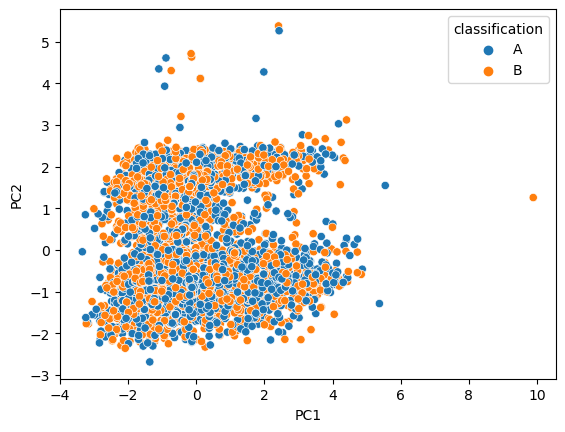

In [13]:
scatterplot_pca(data = bigfoot_fill, hue="classification")

In [14]:
models = [
    (LinearDiscriminantAnalysis, "LDA"),
    (QuadraticDiscriminantAnalysis, "QDA"),
    (GaussianNB, "NB"),
]

def validation_errors(df, models):
    y = df.classification
    X = df.drop(columns=["classification"])
    for model, name in models:
        for acc in cross_val_score(model(), X, y, cv=10):
            yield name, acc

def add_decision_boundaries(df, models):
    colors = sns.color_palette()
    for model, name in models:
        y = df.classification
        X = df.drop(columns=["classification"])
        cls = model()
        cls.fit(X, y)
        add_decision_boundary(cls, label=name, color=colors.pop(), region=False)


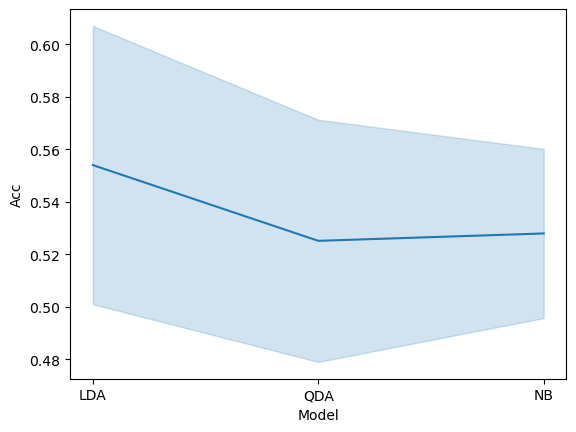

In [15]:
df = pd.DataFrame(validation_errors(bigfoot_fill, models), columns=["Model","Acc"])
sns.lineplot(x="Model", y="Acc", data=df, ci="sd")
plt.show()

In [16]:
df

,Model,Acc
0,LDA,0.550000
1,LDA,0.591182
2,LDA,0.541082
3,LDA,0.509018
4,LDA,0.651303
5,LDA,0.511022
6,LDA,0.583166
7,LDA,0.589178
8,LDA,0.462926
9,LDA,0.551102


In [17]:
df1 = df.groupby(['Model']).mean()
df1

,Acc
Model,
LDA,0.553998
NB,0.527943
QDA,0.525133
